# Out-of-sample forecasting experiments

I conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, I evaluate the performance of dynamic factor models (DFM) using only 10 sentiment-adjusted topics (BPW) most highly correlated with Investment growth (out of 200 topics estimated on articles published before 2008 using all sources). I use text data to forecast Investment growth.

## Experiment Details

- **Data Sources:** 10 sentiment-adjusted topics, BPW (<=2007, 200 topics, all sources).
- **Forecast Target:** Investment growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1
  - **Factor Order:** 3

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'Investment'               # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
with_text = True
only_text = True

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

num_factors = 1
order = 3
      
# Define model-specific parameters
factor_multiplicities = {'Global': num_factors}
factor_orders = {'Global': order}

# Prepare lists to store each quarter's forecasts and row labels
forecasts_all_quarters = []
row_labels = []

# Start timing for this model
start_time = time.time()

# Loop over each forecast month, get the forecasts, and store the results
for fm in forecast_months:
    # Use the forecast_month string as the row label
    row_labels.append(fm)

    # Run the forecast function for this quarter
    forecasts_dict = DFM_function.get_forecasts(
        forecast_month = fm,
        q_var = q_var,
        additional_factors = additional_factors,
        factor_multiplicities = factor_multiplicities,
        factor_orders = factor_orders,
        start = start,
        text_type = text_type,
        estimation_period = estimation_period,
        num_topics = num_topics,
        source = source,
        with_text = with_text,
        only_text = only_text
    )

    # Obtain the correct ordering of vintages
    vintages_order = DFM_function.vintage_dates(fm)
    # Extract the forecast value for each vintage in that order
    quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
    forecasts_all_quarters.append(quarter_forecasts)

# Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)

# Stop timing for this model and print elapsed time
elapsed = time.time() - start_time
elapsed_time = datetime.timedelta(seconds=elapsed)
print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

# Construct the output file name
factors_str = "_".join([
    f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
    for factor in factor_multiplicities])
file_name = f"forecasts_{q_var}_{factors_str}.csv"

# Save the CSV file in a subfolder 
output_path = os.path.join(f"../forecasts/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", file_name)
results.to_csv(output_path, index=True)

# ----- MSE Calculation -----
# Load forecasts
forecasts = pd.read_csv(output_path, index_col=0)
# Make sure the index is a column named "date"
forecasts.index.name = "date"
forecasts.reset_index(inplace=True)

# Merge dfs by date 
merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

# Calculate the Mean Squared Error (MSE) for each vintage column
mse_dict = {}
for col in vintage_col_names:
    mse = ((merged[col] - merged["growth"]) ** 2).mean()
    mse_dict[col] = mse

# Create a df with one row (the MSE values for each forecasting horizon)
mse_df = pd.DataFrame(mse_dict, index=[0])

# Save MSE results to CSV
mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
mse_output_path = os.path.join(f"../MSE/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", mse_file_name)
mse_df.to_csv(mse_output_path, index=False)

EM start iterations, llf=-2184.2
EM converged at iteration 46, llf=-2148.9, convergence criterion=9.4682e-07 < tolerance=1e-06
EM start iterations, llf=-2184.2
EM converged at iteration 46, llf=-2148.9, convergence criterion=9.4682e-07 < tolerance=1e-06
EM start iterations, llf=-2197.6
EM converged at iteration 45, llf=-2162.3, convergence criterion=9.8054e-07 < tolerance=1e-06
EM start iterations, llf=-2197.6
EM converged at iteration 45, llf=-2162.3, convergence criterion=9.8054e-07 < tolerance=1e-06
EM start iterations, llf=-2221.2
EM converged at iteration 46, llf=-2186.1, convergence criterion=9.8389e-07 < tolerance=1e-06
EM start iterations, llf=-2221.2
EM converged at iteration 46, llf=-2186.1, convergence criterion=9.8389e-07 < tolerance=1e-06
EM start iterations, llf=-2237.9
EM converged at iteration 37, llf=-2202.6, convergence criterion=9.6712e-07 < tolerance=1e-06
EM start iterations, llf=-2237.9
EM converged at iteration 37, llf=-2202.6, convergence criterion=9.6712e-07 < 

EM start iterations, llf=-2350.7
EM converged at iteration 27, llf=-2308.4, convergence criterion=9.7739e-07 < tolerance=1e-06
EM start iterations, llf=-2350.7
EM converged at iteration 27, llf=-2308.4, convergence criterion=9.7739e-07 < tolerance=1e-06
EM start iterations, llf=-2369.9
EM converged at iteration 27, llf=-2327, convergence criterion=9.6925e-07 < tolerance=1e-06
EM start iterations, llf=-2369.9
EM converged at iteration 27, llf=-2327, convergence criterion=9.6925e-07 < tolerance=1e-06
EM start iterations, llf=-2382.2
EM converged at iteration 27, llf=-2338.7, convergence criterion=9.6649e-07 < tolerance=1e-06
EM start iterations, llf=-2382.2
EM converged at iteration 27, llf=-2338.7, convergence criterion=9.6649e-07 < tolerance=1e-06
EM start iterations, llf=-2382.2
EM converged at iteration 27, llf=-2338.7, convergence criterion=9.6649e-07 < tolerance=1e-06
EM start iterations, llf=-2394.8
EM converged at iteration 27, llf=-2351.3, convergence criterion=9.6024e-07 < tole

EM start iterations, llf=-2630.3
EM converged at iteration 25, llf=-2586.4, convergence criterion=9.5291e-07 < tolerance=1e-06
EM start iterations, llf=-2630.3
EM converged at iteration 25, llf=-2586.4, convergence criterion=9.5291e-07 < tolerance=1e-06
EM start iterations, llf=-2651.8
EM converged at iteration 25, llf=-2604.5, convergence criterion=9.5446e-07 < tolerance=1e-06
EM start iterations, llf=-2651.8
EM converged at iteration 25, llf=-2604.5, convergence criterion=9.5446e-07 < tolerance=1e-06
EM start iterations, llf=-2651.8
EM converged at iteration 25, llf=-2604.5, convergence criterion=9.5446e-07 < tolerance=1e-06
EM start iterations, llf=-2663.3
EM converged at iteration 25, llf=-2616.1, convergence criterion=9.5045e-07 < tolerance=1e-06
EM start iterations, llf=-2663.3
EM converged at iteration 25, llf=-2616.1, convergence criterion=9.5045e-07 < tolerance=1e-06
EM start iterations, llf=-2676
EM converged at iteration 25, llf=-2628.5, convergence criterion=9.4512e-07 < to

EM start iterations, llf=-2997.1
EM converged at iteration 24, llf=-2944.7, convergence criterion=9.3486e-07 < tolerance=1e-06
EM start iterations, llf=-2997.1
EM converged at iteration 24, llf=-2944.7, convergence criterion=9.3486e-07 < tolerance=1e-06
EM start iterations, llf=-2997.1
EM converged at iteration 24, llf=-2944.7, convergence criterion=9.3486e-07 < tolerance=1e-06
EM start iterations, llf=-3009.5
EM converged at iteration 24, llf=-2956.9, convergence criterion=9.346e-07 < tolerance=1e-06
EM start iterations, llf=-3009.5
EM converged at iteration 24, llf=-2956.9, convergence criterion=9.346e-07 < tolerance=1e-06
EM start iterations, llf=-3023.1
EM converged at iteration 24, llf=-2970.4, convergence criterion=9.312e-07 < tolerance=1e-06
EM start iterations, llf=-3023.1
EM converged at iteration 24, llf=-2970.4, convergence criterion=9.312e-07 < tolerance=1e-06
EM start iterations, llf=-3034.4
EM converged at iteration 24, llf=-2981.2, convergence criterion=9.2753e-07 < tole

EM start iterations, llf=-3311.6
EM converged at iteration 22, llf=-3257.1, convergence criterion=9.977e-07 < tolerance=1e-06
EM start iterations, llf=-3321.7
EM converged at iteration 22, llf=-3267.1, convergence criterion=9.9487e-07 < tolerance=1e-06
EM start iterations, llf=-3321.7
EM converged at iteration 22, llf=-3267.1, convergence criterion=9.9487e-07 < tolerance=1e-06
EM start iterations, llf=-3332.1
EM converged at iteration 22, llf=-3277, convergence criterion=9.936e-07 < tolerance=1e-06
EM start iterations, llf=-3332.1
EM converged at iteration 22, llf=-3277, convergence criterion=9.936e-07 < tolerance=1e-06
EM start iterations, llf=-3341.3
EM converged at iteration 22, llf=-3286.2, convergence criterion=9.9181e-07 < tolerance=1e-06
EM start iterations, llf=-3341.3
EM converged at iteration 22, llf=-3286.2, convergence criterion=9.9181e-07 < tolerance=1e-06
EM start iterations, llf=-3341.3
EM converged at iteration 22, llf=-3286.2, convergence criterion=9.9181e-07 < toleran

Plot MSE values for the model with 1 Global Factor and Lag Order 3 evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


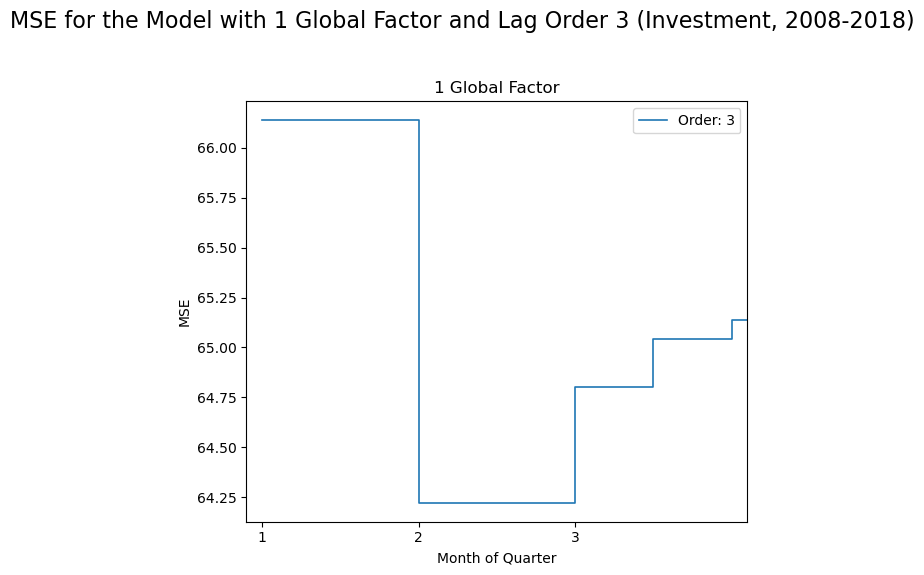

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'Investment'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"

# Create a single‐plot figure for 1 global factor, order 3
fig, ax = plt.subplots(figsize=(6, 6), sharey=True)

num_factors = 1
order = 3
    
# Construct file name based on the model's parameters
factors_str = f"Global_{num_factors}_{order}"
mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
mse_file_path = os.path.join(mse_dir, mse_file_name)

# Load the MSE values from file
mse_df = pd.read_csv(mse_file_path)
# Construct y values based on the vintages
y_values = [mse_df[col].iloc[0] for col in vintage_col_names]

# Extend the y-values so the step function holds the last value
y_extended = y_values.copy()
y_extended.append(y_values[-1]) # Repeat the last value

# Plot the step function for the current model
ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
         label=f"Order: {order}")
        
# Customize the subplot
ax.set_xlabel("Month of Quarter")
# Set ticks only at 1, 2, and 3 to mark the beginning of each month
ax.set_xticks([1, 2, 3])
ax.set_xlim(0.9, 4.1)
ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
ax.set_ylabel("MSE")
ax.legend()

plt.suptitle(f"MSE for the Model with 1 Global Factor and Lag Order 3 ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png", bbox_inches="tight")
plt.savefig(f"{base_filename}.eps", format="eps", bbox_inches="tight")

plt.show()

Plot MSE values for the model with 1 Global Factor and Lag Order 3 evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


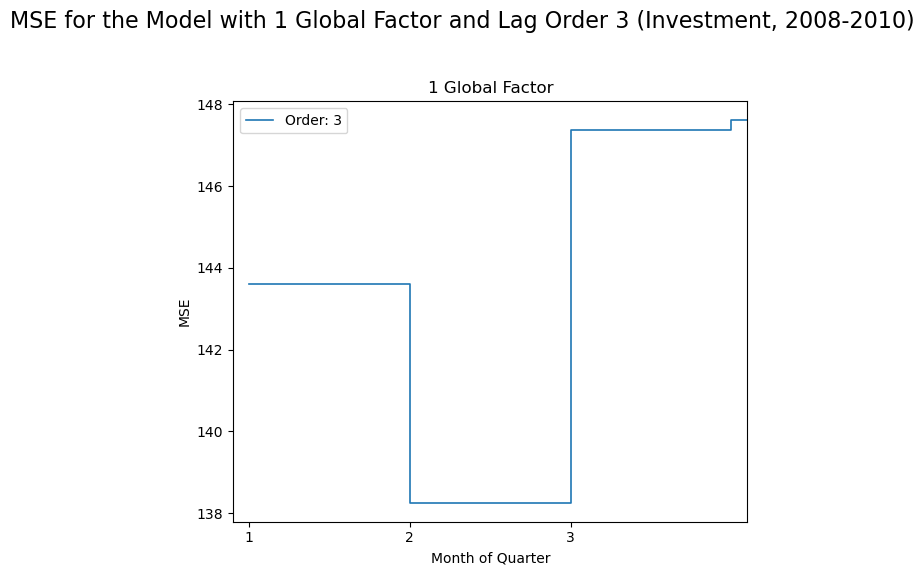

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


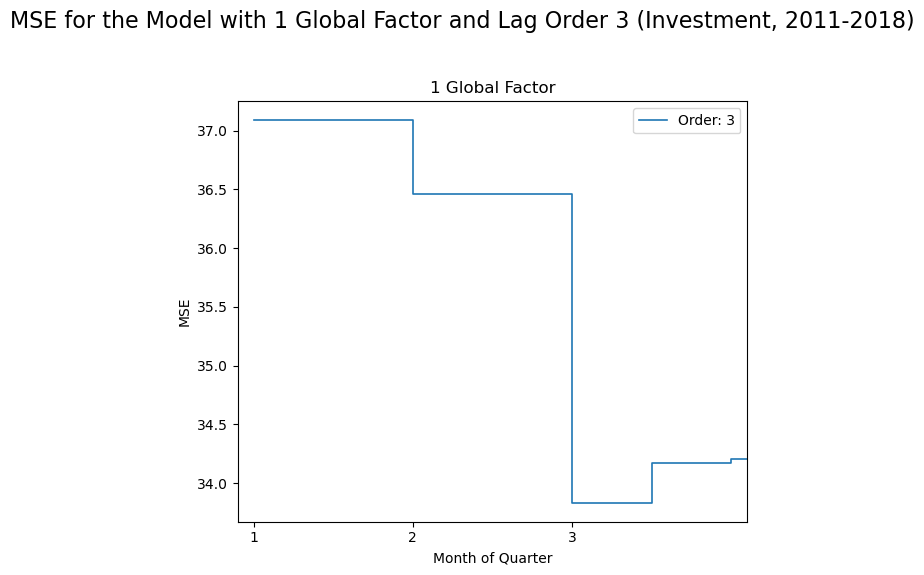

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a single‐plot figure for 1 global factor, order 3
    fig, ax = plt.subplots(figsize=(6, 6), sharey=True)
    
    num_factors = 1
    order = 3
         
    # Construct forecast file name, e.g., "forecasts_Investment_Global_1_1.csv"
    factors_str = f"Global_{num_factors}_{order}"
    forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
    forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

    # Load forecast data 
    forecasts = pd.read_csv(forecast_file_path, index_col=0)
    forecasts.index.name = "date"
    forecasts.reset_index(inplace=True)

    # Merge forecasts with actual growth 
    merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
    merged["date_float"] = merged["date"].apply(quarter_to_float)
    merged.sort_values("date_float", inplace=True)

    # Filter merged data for the current period
    merged_period = merged[ period_filter(merged) ]

    # Calculate MSE for each vintage column over the filtered period
    mse_dict = {}
    for col in vintage_col_names:
        mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
        mse_dict[col] = mse

    # Construct y values based on the vintages
    y_values = [mse_dict[col] for col in vintage_col_names]

    # Extend the y-values so the step function holds the last value
    y_extended = y_values.copy()
    y_extended.append(y_values[-1]) # Repeat the last value

    # Plot the step function for the current model (order)
    ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
            label=f"Order: {order}")
            
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    ax.set_ylabel("MSE")
    ax.legend()
   
    plt.suptitle(f"MSE for the Model with 1 Global Factor and Lag Order 3 ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png", bbox_inches="tight")
    plt.savefig(f"{base_filename}.eps", format="eps", bbox_inches="tight")

    plt.show()

Plot forecasts vs actual growth values for the model with 1 Global Factor, Lag Order 3 and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


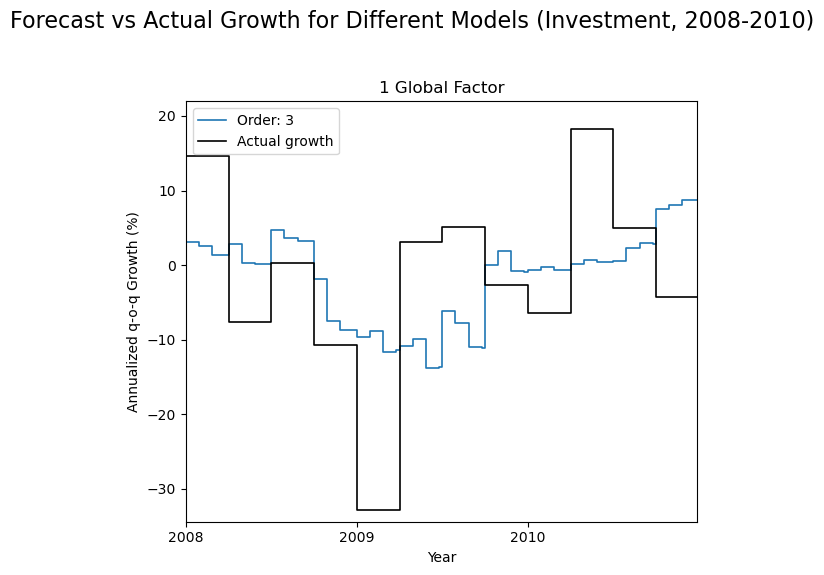

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


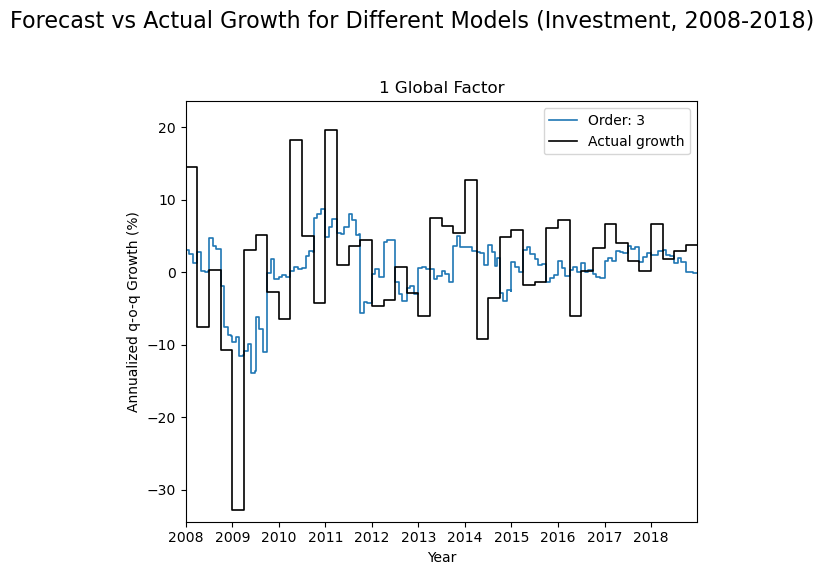

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


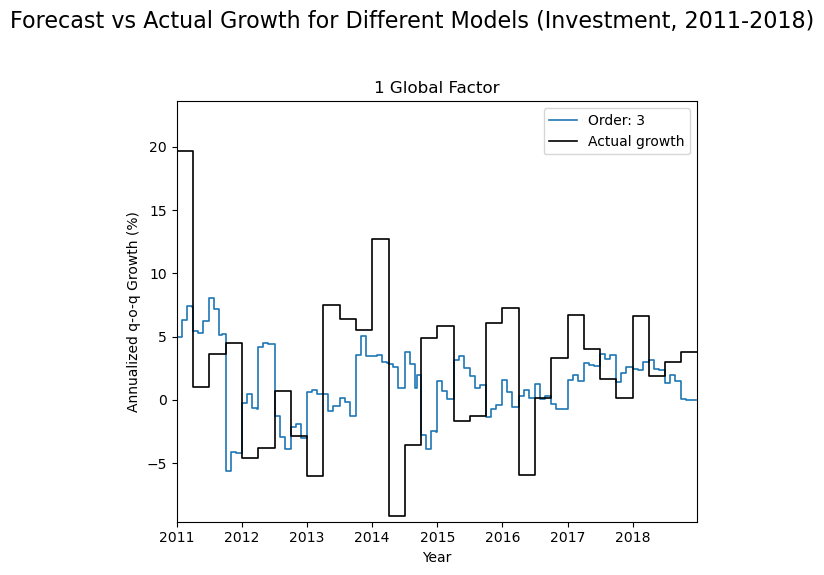

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'Investment'
text_type = "topics_BPW"
estimation_period = "2007"
num_topics = "200"
source = "all"
forecasts_dir = f"../forecasts/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():
    
    # Extend the actual growth arrays so that the step function continues until the end of the x-axis
    if period_label in ["2008-2018", "2011-2018"]:
        x_act_extended = x_act.copy()
        x_act_extended.append(config["xlim"][1])
        y_act_extended = y_act.copy()
        y_act_extended.append(y_act[-1])
    else:
        x_act_extended = x_act
        y_act_extended = y_act

    # Create a single‐plot figure for 1 global factor, order 3
    fig, ax = plt.subplots(figsize=(6, 6), sharey=True)

    num_factors = 1
    order = 3
    
    # Construct forecast file name, e.g., "forecasts_Investment_Global_1_1.csv"
    factors_str = f"Global_{num_factors}_{order}"
    forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
    forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

    # Load forecast data 
    forecasts = pd.read_csv(forecast_file_path, index_col=0)
    forecasts.index.name = "date"
    forecasts.reset_index(inplace=True)

    # Merge forecasts with actual growth dates
    merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
    merged["date_float"] = merged["date"].apply(quarter_to_float)
    merged.sort_values("date_float", inplace=True)

    # Build forecast x and y arrays 
    x_fore = []
    y_fore = []
    for idx, row in merged.iterrows():
        base_x = row["date_float"]
        # For each of the 7 vintage columns, define an x-position and take that forecast value
        for j, col in enumerate(vintage_col_names):
            x_fore.append(base_x + offsets[j])
            y_fore.append(row[col])

    # Plot the forecast step curve for the current order
    ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

    # Plot actual growth as a step plot in each subplot
    ax.step(x_act_extended, y_act_extended, where='post', color='black', linewidth=1.2, label="Actual growth")

    # Customize the subplot
    ax.set_xlabel("Year")
    ax.set_xlim(config["xlim"][0], config["xlim"][1])
    ax.set_xticks(config["xticks"])

    # Set y-axis limits based on the data within the period range
    x_min, x_max = config["xlim"]
    def filter_points(x_arr, y_arr, x_min, x_max):
        return [y for x, y in zip(x_arr, y_arr) if x_min <= x <= x_max]

    # Filter y-values
    y_filtered = filter_points(x_fore, y_fore, x_min, x_max)
    y_act_filtered = filter_points(x_act_extended, y_act_extended, x_min, x_max)

    # Combine all filtered y-values
    combined_y = y_filtered + y_act_filtered
    ax.set_ylim(1.05 * min(combined_y), 1.2 * max(combined_y))

    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    ax.set_ylabel("Annualized q-o-q Growth (%)")
    ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_{q_var}", f"DFM_only_{text_type}_{estimation_period}_{num_topics}_{source}_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png", bbox_inches="tight")
    plt.savefig(f"{base_filename}.eps", format="eps", bbox_inches="tight")

    plt.show()